#### Case 1: Isobaric evaporation of liquid hydrogen in a 4.89 $m^3$ spherical tank experiments.

This notebook sets up the isobaric evaporation of liquid hydrogen ($LH_2$) in a 4.89 $m^3$ storage tank. A high liquid filling, high heat ingress scenario from Hasan (1991) is considered. This tank is representative of lab-scale tanks used for cryogen evaporation experiments that measure boil-off rates and thermal stratification.

In [333]:
# Ensure that python finds the submodules
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

## Module imports
# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

from scipy.integrate import simps

#### Setup tank and cryogen properties

In [334]:
# LNG tank properties
Q_roof = 0 # Roof heat ingress / W
d_i = 2.106 # Internal diameter / m
d_o = 2.106+2.08e-3   # External diameter / m
T_air = 350 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 0.01063 # W/m2/K
U_V = 0.01063 # W/m2/K

# Specify heat transfer rate at the bottom to prevent ground heating
Q_b = 0 # W, 

# Spherical tank volume
V_tank = 4.89 #m^3

# Initial liquid filling / Dimensionless
LF = 0.95

# Specify tank operating pressure
P = 117e3 # Pa

Geo_v1 = "spherical"

Geo_l1 = "spherical"

# Initialize large-scale tank
small_tank1 = Tank(d_i, d_o, V_tank, Geo_v1, Geo_l1,LF)
small_tank1.set_HeatTransProps(U_L, U_V, T_air, Q_roof, Q_b, eta_w = 0.95)

# Initialise cryogen
hydrogen1 = Cryogen(name = "hydrogen")
hydrogen1.set_coolprops(P)


# Set cryogen
small_tank1.cryogen = hydrogen1

# Calculate initial evaporation rate
print("The initial evaporation rate of " + hydrogen1.name + " is %.1e kg/h" % (small_tank1.b_l_dot * 3600))

The initial evaporation rate of hydrogen is 3.9e-01 kg/h


Calculate initial evaporation rate and transient period

In [335]:
# Calculate initial evaporation rate
print("The initial evaporation rate of " + hydrogen1.name + " is %.1e kg/h" % (small_tank1.b_l_dot * 3600))

# Estimate transient period duration
print("Transient period = %.3f s " % small_tank1.tau)

# Minimum number of hours to achieve steady state 
tau_h1 = (np.floor(small_tank1.tau / 3600) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i h" % tau_h1 )

# Calculate boil-off rate
BOR1 = (small_tank1.b_l_dot * 24 * 3600) / (small_tank1.V * small_tank1.LF * small_tank1.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR1 * 100))

The initial evaporation rate of hydrogen is 3.9e-01 kg/h
Transient period = 6505.059 s 
Simulation time: 2 h
BOR = 2.877 %


#### Simulation setup and execution

In [336]:
# Define vertical spacing
dz = 0.005

# Calculate number of nodes
n_z = 1 + int(np.round(small_tank1.l_V/dz, 0))

# Define dimensionless computational grid
small_tank1.z_grid = np.linspace(0, 1, n_z)

# Insulated roof
small_tank1.U_roof = 0

# Define evaporation time as twice as the transient period
#evap_time = 3600 *tau_h1*4
evap_time = 3600*50

# Time step to record data, relevant for plotting integrated quantities
# such as the vapour to liquid heat transfer rate, Q_VL
small_tank1.time_interval = 60

# Time step to plot each vapour temperature profile
small_tank1.plot_interval = evap_time/6

# Simulate the evaporation
small_tank1.evaporate(evap_time)

#### Visualisation of results

#### Vapour temperature

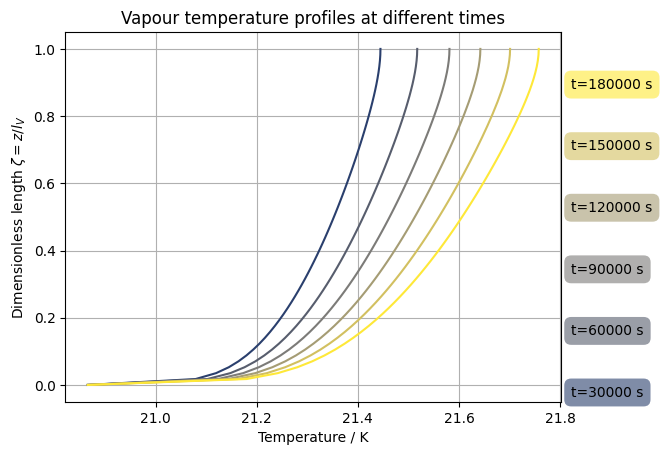

In [337]:
# Visualise the plot
small_tank1.plot_tv()

Visualise liquid and vapour heat ingresses, $\dot{Q}_{\text{L}}$ and  $\dot{Q}_{\text{V}}$.

The plot also shows the vapour to liquid heat ingress, $\dot{Q}_{VL}$, and  the partition of the vapour heat ingress that is transferred to the interface by the wall directly, $\dot{Q}_{\text{V,w}}$

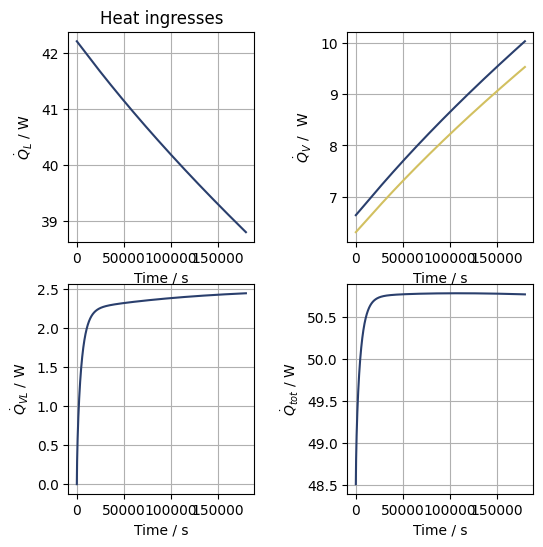

In [338]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank1.plot_Q(unit="W")

#### Plot liquid volume

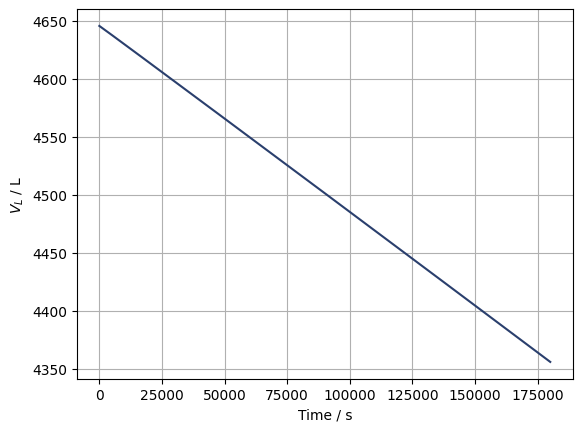

In [339]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank1.plot_V_L(unit="L")

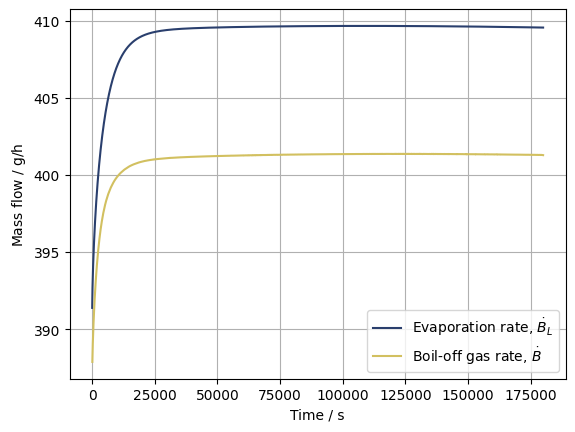

In [340]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank1.plot_BOG(unit='g/h')

In [341]:
print(len(small_tank1.data["BOG"]))

3001


In [342]:
small_tank1.data["Pressure"] = np.ones_like(small_tank1.data["B_L"])*P
air = P*(V_tank*(1-LF))/(8.314*hydrogen1.T_sat)
for i in range(1,len(small_tank1.data["B_L"])):
    small_tank1.data["Pressure"][i] = ((simps(small_tank1.data["B_L"][:i])*(1000/2) +air)*8.314*small_tank1.data["Tv_avg"][i])/(V_tank - small_tank1.data["V_L"][i])

Optional: CSV data export

If evaporation data is intended to be post-processed in another software, it can be exported readily with the help of the Pandas package.

In [343]:
# Import pandas 
import pandas as pd

In [344]:
# Create dataframe from dictionary
df_evap = pd.DataFrame.from_dict(small_tank1.data)

# Save file to the current working directory
df_evap.to_csv('LN2_small_m3.csv')

# Show the first five columns of the dataframe in console
df_evap[-5:]

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,dV_L,z,A_T,LF,Q_Vw,Pressure
2996,179760,21.527927,1.456573,2.443771,38.798161,10.027727,4.356413,0.000114,0.000111,-1.167618e-07,-0.000002,1.673395,2.274257,0.890882,9.526341,112399.041615
2997,179820,21.528010,1.456566,2.443804,38.797172,10.028713,4.356316,0.000114,0.000111,-1.174983e-07,-0.000002,1.673353,2.274423,0.890862,9.527277,112398.093331
2998,179880,21.528089,1.456559,2.443837,38.796182,10.029698,4.356218,0.000114,0.000111,-1.169592e-07,-0.000002,1.673310,2.274590,0.890842,9.528213,112397.127092
2999,179940,21.528171,1.456552,2.443870,38.795193,10.030683,4.356121,0.000114,0.000111,-1.162590e-07,-0.000002,1.673267,2.274756,0.890822,9.529149,112396.175707
3000,180000,21.528249,1.456545,2.443903,38.794203,10.031668,4.356024,0.000114,0.000111,-1.109242e-07,-0.000002,1.673225,2.274923,0.890802,9.530084,112395.205185


In [345]:
df_evap['flux_v'] = df_evap["Q_V"]/(np.pi*d_i*(d_i-df_evap['z']))
df_evap['flux_l'] = df_evap["Q_L"]/(np.pi*d_i*(df_evap['z']))
df_evap['total_flux'] = (df_evap['Q_L']+df_evap['Q_V'])/(np.pi*d_i**2)
df_evap.head()
df_evap[-5:]

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,dV_L,z,A_T,LF,Q_Vw,Pressure,flux_v,flux_l
2996,179760,21.527927,1.456573,2.443771,38.798161,10.027727,4.356413,0.000114,0.000111,-1.167618e-07,-0.000002,1.673395,2.274257,0.890882,9.526341,112399.041615,3.491658,3.498692
2997,179820,21.528010,1.456566,2.443804,38.797172,10.028713,4.356316,0.000114,0.000111,-1.174983e-07,-0.000002,1.673353,2.274423,0.890862,9.527277,112398.093331,3.491657,3.498692
2998,179880,21.528089,1.456559,2.443837,38.796182,10.029698,4.356218,0.000114,0.000111,-1.169592e-07,-0.000002,1.673310,2.274590,0.890842,9.528213,112397.127092,3.491656,3.498692
2999,179940,21.528171,1.456552,2.443870,38.795193,10.030683,4.356121,0.000114,0.000111,-1.162590e-07,-0.000002,1.673267,2.274756,0.890822,9.529149,112396.175707,3.491656,3.498692
3000,180000,21.528249,1.456545,2.443903,38.794203,10.031668,4.356024,0.000114,0.000111,-1.109242e-07,-0.000002,1.673225,2.274923,0.890802,9.530084,112395.205185,3.491655,3.498692


In [346]:
df_evap.head()

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,dV_L,z,A_T,LF,Q_Vw,Pressure,flux_v,flux_l
0,0,20.866191,1.517286,-1.459055e-14,42.207326,6.638764,4.645500,0.000109,0.000109,0.000000,0.000000,1.820527,1.632722,0.950000,6.306826,117000.000000,3.498692,3.498692
1,60,20.869202,1.517001,9.652218e-02,42.206008,6.640021,4.645407,0.000109,0.000108,-0.000005,-0.000002,1.820470,1.632996,0.949981,6.308020,116972.443370,3.498660,3.498692
2,120,20.872145,1.516717,1.599150e-01,42.204689,6.641281,4.645314,0.000109,0.000108,-0.000005,-0.000002,1.820413,1.633271,0.949962,6.309217,116983.069308,3.498629,3.498692
3,180,20.875059,1.516435,2.117010e-01,42.203369,6.642543,4.645221,0.000109,0.000108,-0.000005,-0.000002,1.820356,1.633545,0.949943,6.310415,116993.561142,3.498598,3.498692
4,240,20.877948,1.516156,2.570889e-01,42.202048,6.643805,4.645128,0.000109,0.000108,-0.000005,-0.000002,1.820299,1.633820,0.949924,6.311615,117003.927223,3.498567,3.498692


In [348]:
df_evap["SCHM BOG"] = ((df_evap["BOG"]*1000*3600/2)*(273+15)*8.314)/101325
df_evap[-5:]

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,dV_L,z,A_T,LF,Q_Vw,Pressure,flux_v,flux_l,SCHM BOG
2996,179760,21.527927,1.456573,2.443771,38.798161,10.027727,4.356413,0.000114,0.000111,-1.167618e-07,-0.000002,1.673395,2.274257,0.890882,9.526341,112399.041615,3.491658,3.498692,4.741596
2997,179820,21.528010,1.456566,2.443804,38.797172,10.028713,4.356316,0.000114,0.000111,-1.174983e-07,-0.000002,1.673353,2.274423,0.890862,9.527277,112398.093331,3.491657,3.498692,4.741611
2998,179880,21.528089,1.456559,2.443837,38.796182,10.029698,4.356218,0.000114,0.000111,-1.169592e-07,-0.000002,1.673310,2.274590,0.890842,9.528213,112397.127092,3.491656,3.498692,4.741597
2999,179940,21.528171,1.456552,2.443870,38.795193,10.030683,4.356121,0.000114,0.000111,-1.162590e-07,-0.000002,1.673267,2.274756,0.890822,9.529149,112396.175707,3.491656,3.498692,4.741580
3000,180000,21.528249,1.456545,2.443903,38.794203,10.031668,4.356024,0.000114,0.000111,-1.109242e-07,-0.000002,1.673225,2.274923,0.890802,9.530084,112395.205185,3.491655,3.498692,4.741458


#### References



Hasan, M., Lin, C. and Van Dresar, N. (1991). Self-Pressurization of a Flightweight Liquid Hydrogen Storage Tank Subjected to Low Heat Flux. [online] Available at: https://ntrs.nasa.gov/api/citations/19910011011/downloads/19910011011.pdf [Accessed 2 Jul. 2024].

Wang, Z. and Mérida, W. (2024). Thermal performance of cylindrical and spherical liquid hydrogen tanks. International Journal of Hydrogen Energy, 53, pp.667–683. doi:https://doi.org/10.1016/j.ijhydene.2023.11.287.